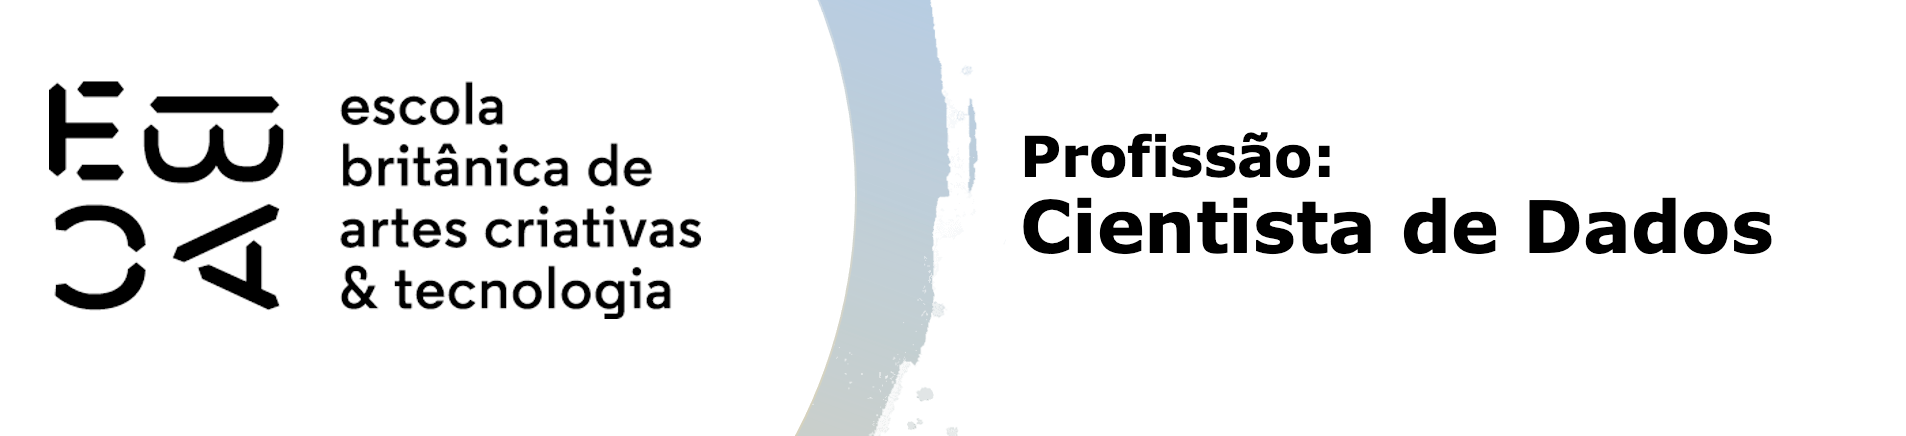

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [43]:

# Garantir que a coluna 'Data Emissão' está no formato datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# 1. Criar coluna dia da semana (0=segunda, 6=domingo)
df['dia_semana'] = df['Data Emissão'].dt.dayofweek

# 2. Criar dummy para fim de semana (1 se sábado ou domingo)
df['fim_de_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)

# 3. Criar dia do mês
df['dia_mes'] = df['Data Emissão'].dt.day

# 4. Criar trimestre
df['trimestre'] = df['Data Emissão'].dt.quarter

# Exibir as primeiras linhas para conferir
df[['Data Emissão', 'dia_semana', 'fim_de_semana', 'dia_mes', 'trimestre']].head()


,Data Emissão,dia_semana,fim_de_semana,dia_mes,trimestre
0,2017-06-30,4,0,30,2
1,2017-06-30,4,0,30,2
2,2017-06-30,4,0,30,2
3,2017-06-30,4,0,30,2
4,2017-06-30,4,0,30,2


In [44]:
# Garantir que não há valores NaN na variável Valor NF antes de categorizar
df = df[df['Valor NF'].notnull()]

# Categorizar em 5 quantis
df['valor_nf_q5'] = pd.qcut(df['Valor NF'], q=5, duplicates='drop')

# Categorizar em 10 quantis
df['valor_nf_q10'] = pd.qcut(df['Valor NF'], q=10, duplicates='drop')

# Categorizar em 20 quantis
df['valor_nf_q20'] = pd.qcut(df['Valor NF'], q=20, duplicates='drop')

# Categorizar em 50 quantis
df['valor_nf_q50'] = pd.qcut(df['Valor NF'], q=50, duplicates='drop')

# Visualizar um exemplo
df[['Valor NF', 'valor_nf_q5', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50']].head()


,Valor NF,valor_nf_q5,valor_nf_q10,valor_nf_q20,valor_nf_q50
0,24.68,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,50.00,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,27.00,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,111.50,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,125.00,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


In [45]:
# criação de retorno_positivo (binário)

df['retorno_positivo'] = (df['Retorno'] > 0).astype(int)


C:\Users\Cristina\AppData\Local\Temp\ipykernel_7480\2436052169.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo_Quantil', y='Valor NF', data=df_long, palette='viridis')


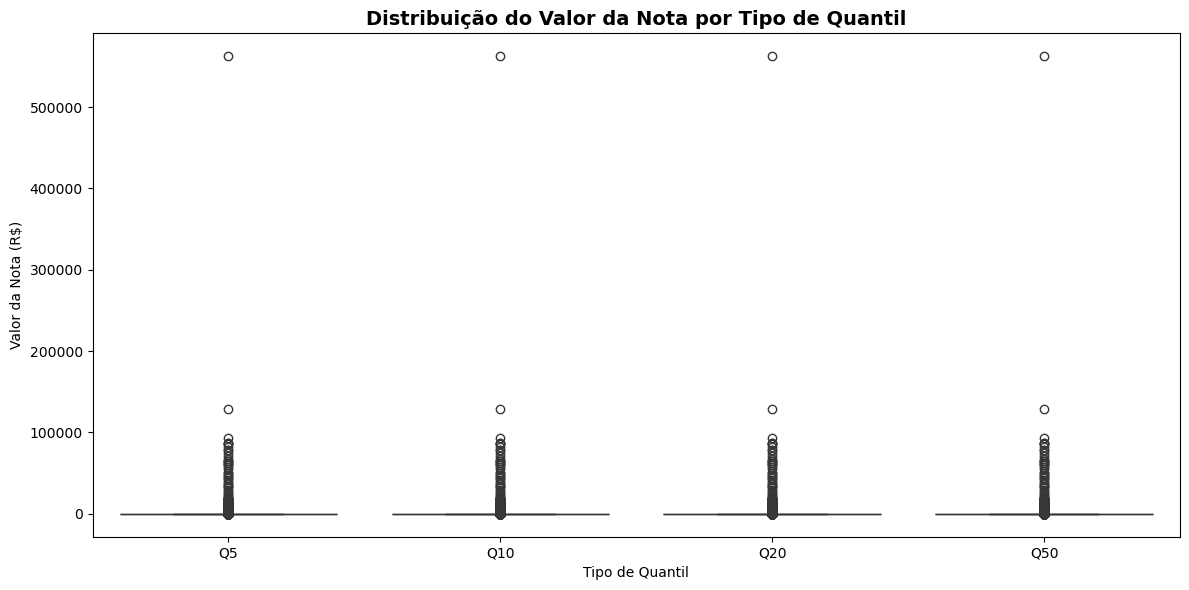

In [46]:
# Criar um DataFrame empilhado (long format)
df_long = pd.melt(
    df,
    id_vars=['Valor NF'],
    value_vars=['valor_nf_q5', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50'],
    var_name='Grupo_Quantil',
    value_name='Faixa_Quantil'
)

# Ajustar os nomes dos grupos para ficar mais legível
df_long['Grupo_Quantil'] = df_long['Grupo_Quantil'].replace({
    'valor_nf_q5': 'Q5',
    'valor_nf_q10': 'Q10',
    'valor_nf_q20': 'Q20',
    'valor_nf_q50': 'Q50'
})

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='Grupo_Quantil', y='Valor NF', data=df_long, palette='viridis')

plt.title('Distribuição do Valor da Nota por Tipo de Quantil', fontsize=14, weight='bold')
plt.xlabel('Tipo de Quantil')
plt.ylabel('Valor da Nota (R$)')
plt.tight_layout()
plt.show()

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [51]:
# função calcula WOE e IV

def calcula_woe_iv(df, feature, target):
    tab = pd.crosstab(df[feature], df[target])

    # Mapear as colunas automaticamente
    col_map = {}
    for col in tab.columns:
        if col in [0, False]:
            col_map[col] = 'Non_Event'
        elif col in [1, True]:
            col_map[col] = 'Event'
    tab = tab.rename(columns=col_map)

    # Se alguma coluna não existir, cria com valores pequenos para evitar erros
    if 'Non_Event' not in tab.columns:
        tab['Non_Event'] = 0.0001
    if 'Event' not in tab.columns:
        tab['Event'] = 0.0001

    # Ajustar zeros para evitar erro log
    tab['Non_Event'] = tab['Non_Event'].replace(0, 0.0001)
    tab['Event'] = tab['Event'].replace(0, 0.0001)

    # Distribuições
    tab['Dist_Non_Event'] = tab['Non_Event'] / tab['Non_Event'].sum()
    tab['Dist_Event'] = tab['Event'] / tab['Event'].sum()

    # WOE
    tab['WOE'] = np.log(tab['Dist_Event'] / tab['Dist_Non_Event'])

    # IV
    tab['IV'] = (tab['Dist_Event'] - tab['Dist_Non_Event']) * tab['WOE']

    iv = tab['IV'].sum()

    return tab, iv



In [48]:
# variáveis categóricas

variaveis_categoricas = [
    'Emitente',
    'CNPJ emit.',
    'categoria',
    'Situação do Crédito',
    'valor_nf_q5',
    'valor_nf_q10',
    'valor_nf_q20',
    'valor_nf_q50',
    'dia_semana',
    'fim_de_semana',
    'dia_mes',
    'trimestre'
]


In [52]:
iv_resultados = {}

for var in variaveis_categoricas:
    if var in df.columns:
        try:
            _, iv = calcula_woe_iv(df, var, 'retorno_positivo')
            iv_resultados[var] = iv
        except Exception as e:
            print(f'Erro ao calcular IV para a variável {var}: {e}')
    else:
        print(f'Variável {var} não encontrada no DataFrame')

import pandas as pd
from IPython.display import display

iv_df = pd.DataFrame.from_dict(iv_resultados, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
display(iv_df)



,IV
CNPJ emit.,12.996604
Emitente,12.013066
categoria,0.408313
valor_nf_q50,0.152315
valor_nf_q20,0.124525
valor_nf_q10,0.106650
valor_nf_q5,0.056695
dia_mes,0.043719
trimestre,0.011507
dia_semana,0.006883


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<span style="color:red;">
As variáveis temporais como dia_mes, trimestre, dia_semana e fim_de_semana têm IV muito baixo, indicando que têm pouco poder discriminativo. Tirando CNPJ emit. e emitente que são variáveis que tem cardinalidade alta (possui muitas categorias únicas ou valores distintos) a variável mais significativa é a variável categoria.
</span>


## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

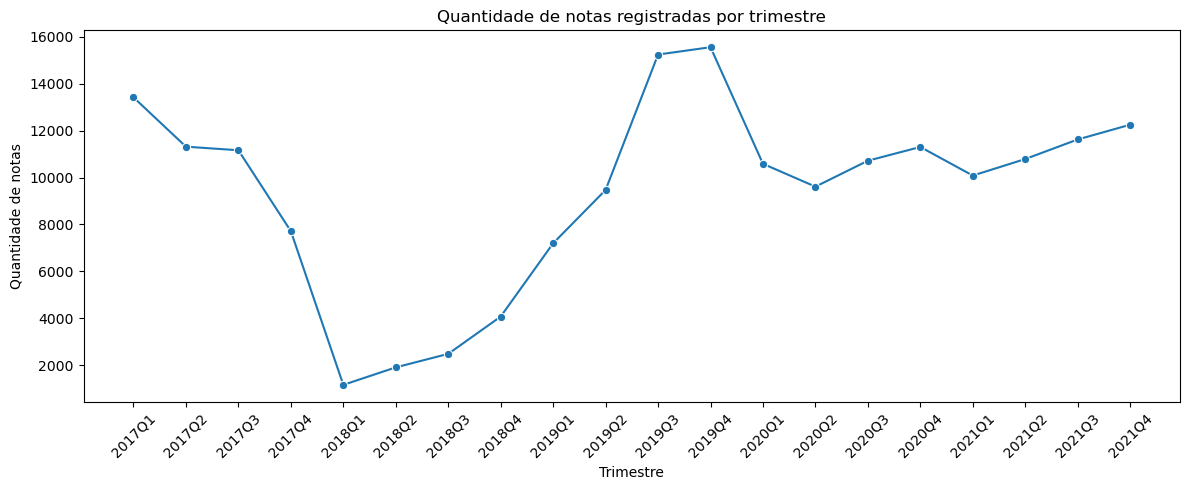

In [57]:
# 1. Quantidade total de notas por trimestre

notas_por_trimestre['trimestre'] = notas_por_trimestre['trimestre'].astype(str)

# notas_por_trimestre = df.groupby('trimestre').size().reset_index(name='quantidade_notas')

plt.figure(figsize=(12,5))
sns.lineplot(data=notas_por_trimestre, x='trimestre', y='quantidade_notas', marker='o')
plt.title('Quantidade de notas registradas por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

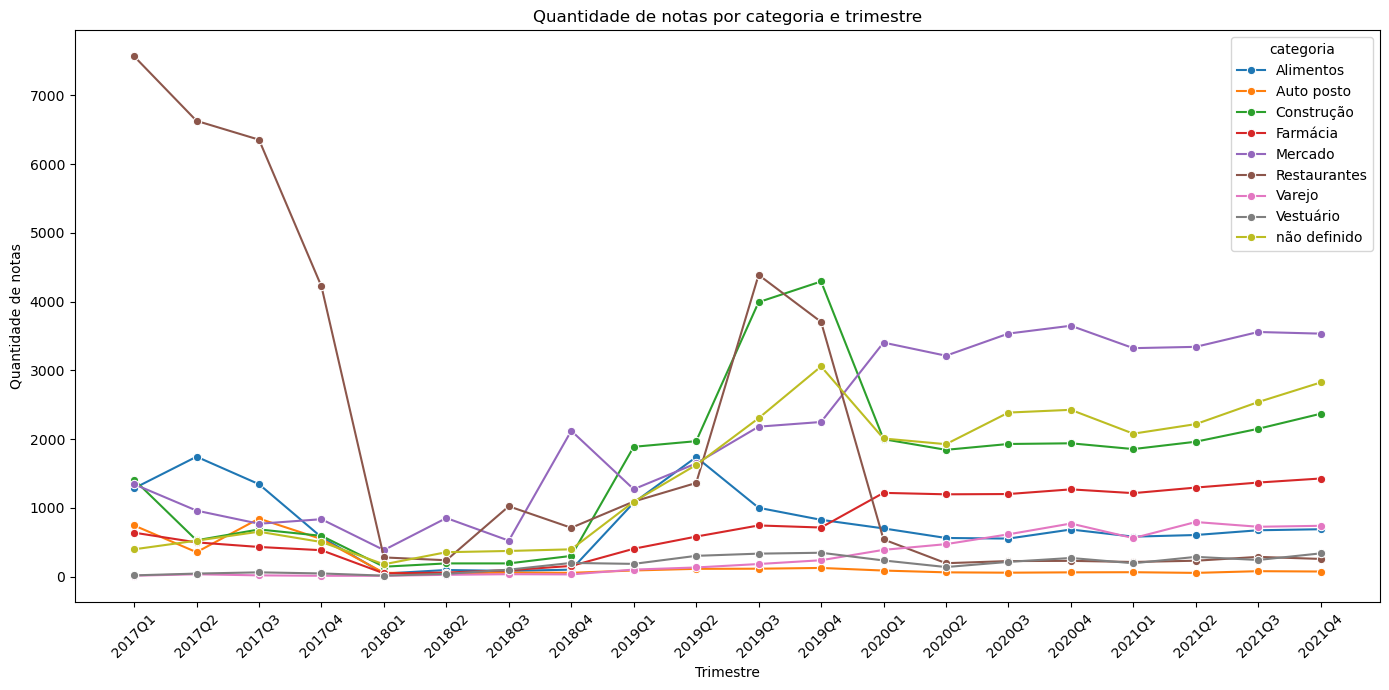

In [61]:
# 2. Quantidade de notas por categoria e trimestre

notas_categoria_trimestre = df.groupby(['trimestre', 'categoria']).size().reset_index(name='quantidade')
notas_categoria_trimestre['trimestre'] = notas_categoria_trimestre['trimestre'].astype(str)

plt.figure(figsize=(14,7))
sns.lineplot(data=notas_categoria_trimestre, x='trimestre', y='quantidade', hue='categoria', marker='o')
plt.title('Quantidade de notas por categoria e trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de notas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


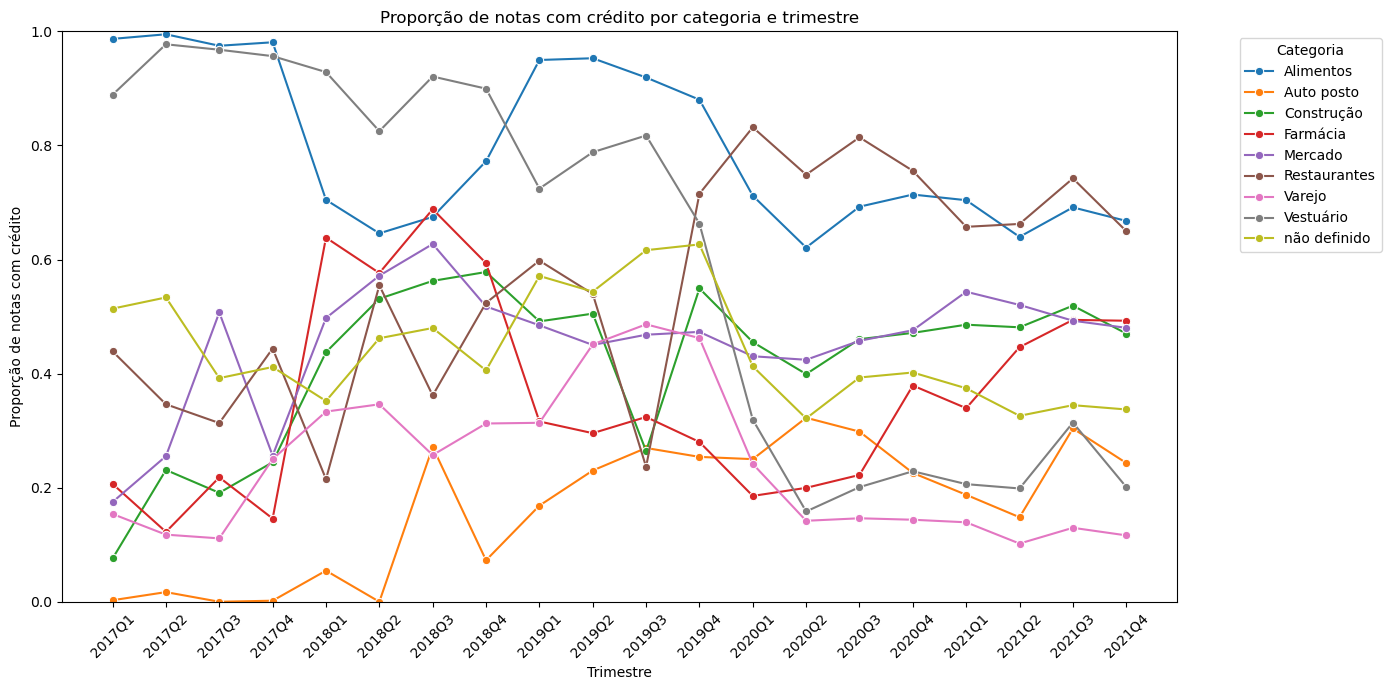

In [64]:
# 3. Proporção de notas com crédito por categoria e trimestre

# Considerando 'notas com crédito' = Créditos > 0
df['nota_com_credito'] = df['Créditos'] > 0

credito_categoria_trimestre['trimestre'] = credito_categoria_trimestre['trimestre'].astype(str)
credito_categoria_trimestre['proporcao_com_credito'] = pd.to_numeric(credito_categoria_trimestre['proporcao_com_credito'], errors='coerce')

plt.figure(figsize=(14,7))
sns.lineplot(data=credito_categoria_trimestre, x='trimestre', y='proporcao_com_credito', hue='categoria', marker='o')
plt.title('Proporção de notas com crédito por categoria e trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de notas com crédito')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [66]:
# Função para calcular WOE e IV dada uma tabela de contingência

def calcula_woe_iv(df, feature, target):
    tab = pd.crosstab(df[feature], df[target])
    tab.columns = ['Non_Event', 'Event']

    # Ajustar zero para evitar erro de log
    tab['Non_Event'] = tab['Non_Event'].replace(0, 0.0001)
    tab['Event'] = tab['Event'].replace(0, 0.0001)

    # Distribuições
    tab['Dist_Non_Event'] = tab['Non_Event'] / tab['Non_Event'].sum()
    tab['Dist_Event'] = tab['Event'] / tab['Event'].sum()

    # WOE
    tab['WOE'] = np.log(tab['Dist_Event'] / tab['Dist_Non_Event'])

    # IV
    tab['IV'] = (tab['Dist_Event'] - tab['Dist_Non_Event']) * tab['WOE']

    iv = tab['IV'].sum()
    return tab, iv




Trimestre 2017Q1 - IV: 2.0880


,WOE,IV
categoria,,
Alimentos,4.742104,1.127185
Auto posto,-5.486081,0.498623
Construção,-2.069475,0.289801
Farmácia,-0.915588,0.034242
Mercado,-1.121508,0.103143
Restaurantes,0.184710,0.019570
Varejo,-1.274627,0.001243
Vestuário,2.509562,0.006976
não definido,0.485551,0.007205


Trimestre 2017Q2 - IV: 2.4856


,WOE,IV
categoria,,
Alimentos,5.570649,2.010077
Auto posto,-3.754202,0.196097
Construção,-0.893222,0.032828
Farmácia,-1.659949,0.090033
Mercado,-0.761914,0.044519
Restaurantes,-0.326648,0.060460
Varejo,-1.705792,0.006418
Vestuário,4.070311,0.035916
não definido,0.443154,0.009241


Trimestre 2017Q3 - IV: 3.3355


,WOE,IV
categoria,,
Alimentos,4.143846,1.261770
Auto posto,-15.456069,1.882927
Construção,-0.951347,0.046777
Farmácia,-0.784364,0.020740
Mercado,0.521035,0.019490
Restaurantes,-0.292328,0.046675
Varejo,-1.587018,0.002916
Vestuário,3.893621,0.054052
não definido,0.053665,0.000170


Trimestre 2017Q4 - IV: 1.6885


,WOE,IV
categoria,,
Alimentos,4.327848,0.772748
Auto posto,-5.906545,0.696832
Construção,-0.733818,0.037101
Farmácia,-1.373421,0.073020
Mercado,-0.671114,0.044224
Restaurantes,0.169178,0.015887
Varejo,-0.704371,0.000696
Vestuário,3.485284,0.047860
não definido,0.036601,0.000088


Trimestre 2018Q1 - IV: 0.5753


,WOE,IV
categoria,,
Alimentos,1.292496,0.063323
Auto posto,-2.429174,0.164319
Construção,0.172143,0.003736
Farmácia,0.991442,0.040757
Mercado,0.413095,0.058475
Restaurantes,-0.871269,0.158303
Varejo,-0.269690,0.000728
Vestuário,2.988407,0.080376
não definido,-0.186998,0.005278


Trimestre 2018Q2 - IV: 0.7986


,WOE,IV
categoria,,
Alimentos,0.453604,0.010025
Auto posto,-13.228711,0.719113
Construção,-0.022007,0.000049
Farmácia,0.160315,0.000789
Mercado,0.141197,0.008851
Restaurantes,0.072193,0.000649
Varejo,-0.783158,0.008188
Vestuário,1.403428,0.034146
não definido,-0.299577,0.016775


Trimestre 2018Q3 - IV: 0.4346


,WOE,IV
categoria,,
Alimentos,0.758526,0.018465
Auto posto,-0.959600,0.020220
Construção,0.280325,0.006052
Farmácia,0.820598,0.024040
Mercado,0.549025,0.062209
Restaurantes,-0.539063,0.116508
Varejo,-1.031861,0.013716
Vestuário,2.482169,0.172978
não definido,-0.051461,0.000398


Trimestre 2018Q4 - IV: 0.2801


,WOE,IV
categoria,,
Alimentos,1.090841,0.026062
Auto posto,-2.675905,0.066777
Construção,0.184495,0.002495
Farmácia,0.248280,0.002316
Mercado,-0.059623,0.001855
Restaurantes,-0.034526,0.000208
Varejo,-0.918831,0.006384
Vestuário,2.061280,0.148525
não definido,-0.512801,0.025513


Trimestre 2019Q1 - IV: 0.7891


,WOE,IV
categoria,,
Alimentos,2.630844,0.600782
Auto posto,-1.904725,0.039372
Construção,-0.342611,0.031313
Farmácia,-1.080697,0.064905
Mercado,-0.370098,0.024610
Restaurantes,0.088368,0.001176
Varejo,-1.091469,0.016657
Vestuário,0.657304,0.010227
não definido,-0.022099,0.000074


Trimestre 2019Q2 - IV: 0.9711


,WOE,IV
categoria,,
Alimentos,2.676856,0.749725
Auto posto,-1.536396,0.026465
Construção,-0.308280,0.020116
Farmácia,-1.197247,0.086432
Mercado,-0.528519,0.049535
Restaurantes,-0.169661,0.004188
Varejo,-0.524700,0.003945
Vestuário,0.984803,0.026669
não definido,-0.153260,0.004071


Trimestre 2019Q3 - IV: 0.8577


,WOE,IV
categoria,,
Alimentos,2.837796,0.403729
Auto posto,-0.588958,0.002406
Construção,-0.615977,0.090888
Farmácia,-0.327922,0.005038
Mercado,0.280234,0.011486
Restaurantes,-0.763793,0.149292
Varejo,0.353213,0.001537
Vestuário,1.906469,0.072786
não definido,0.881826,0.120524


Trimestre 2019Q4 - IV: 0.3170


,WOE,IV
categoria,,
Alimentos,1.600916,0.100054
Auto posto,-1.470450,0.016981
Construção,-0.195185,0.010683
Farmácia,-1.336797,0.080813
Mercado,-0.500598,0.037267
Restaurantes,0.528128,0.061837
Varejo,-0.544441,0.004667
Vestuário,0.283014,0.001728
não definido,0.124045,0.002984


Trimestre 2020Q1 - IV: 0.4220


,WOE,IV
categoria,,
Alimentos,1.178915,0.089128
Auto posto,-0.824035,0.005076
Construção,0.095006,0.001715
Farmácia,-1.204611,0.139127
Mercado,-0.005740,0.000011
Restaurantes,1.872965,0.156087
Varejo,-0.869104,0.024755
Vestuário,-0.483109,0.004924
não definido,-0.078473,0.001162


Trimestre 2020Q2 - IV: 0.3017


,WOE,IV
categoria,,
Alimentos,1.023631,0.064278
Auto posto,-0.212086,0.000281
Construção,0.120770,0.002840
Farmácia,-0.858533,0.078347
Mercado,0.224354,0.017258
Restaurantes,1.621638,0.053351
Varejo,-1.269343,0.061104
Vestuário,-1.141280,0.015024
não definido,-0.217533,0.009189


Trimestre 2020Q3 - IV: 0.3401


,WOE,IV
categoria,,
Alimentos,1.163316,0.069198
Auto posto,-0.504586,0.001272
Construção,0.192115,0.006736
Farmácia,-0.901148,0.079483
Mercado,0.180370,0.010873
Restaurantes,1.828346,0.063782
Varejo,-1.412509,0.089199
Vestuário,-1.029384,0.017991
não definido,-0.083109,0.001526


Trimestre 2020Q4 - IV: 0.2867


,WOE,IV
categoria,,
Alimentos,1.161474,0.078728
Auto posto,-0.984918,0.004667
Construção,0.132608,0.003037
Farmácia,-0.246405,0.006682
Mercado,0.151235,0.007440
Restaurantes,1.375166,0.035868
Varejo,-1.536998,0.125670
Vestuário,-0.967974,0.019770
não definido,-0.150345,0.004799


Trimestre 2021Q1 - IV: 0.3165


,WOE,IV
categoria,,
Alimentos,1.051415,0.061136
Auto posto,-1.281142,0.008738
Construção,0.128036,0.003030
Farmácia,-0.480891,0.026736
Mercado,0.359575,0.042861
Restaurantes,0.836378,0.014502
Varejo,-1.636041,0.115307
Vestuário,-1.162878,0.022354
não definido,-0.328967,0.021787


Trimestre 2021Q2 - IV: 0.3718


,WOE,IV
categoria,,
Alimentos,0.844006,0.039868
Auto posto,-1.479124,0.008587
Construção,0.194607,0.006957
Farmácia,0.054574,0.000359
Mercado,0.351510,0.038794
Restaurantes,0.943805,0.018888
Varejo,-1.904956,0.188965
Vestuário,-1.124952,0.028561
não definido,-0.456396,0.040867


Trimestre 2021Q3 - IV: 0.3080


,WOE,IV
categoria,,
Alimentos,0.985405,0.054371
Auto posto,-0.650522,0.002703
Construção,0.255073,0.012108
Farmácia,0.155364,0.002855
Mercado,0.149525,0.006878
Restaurantes,1.235984,0.035287
Varejo,-1.725254,0.141368
Vestuário,-0.602497,0.007152
não definido,-0.463999,0.045288


Trimestre 2021Q4 - IV: 0.2963


,WOE,IV
categoria,,
Alimentos,0.980331,0.053516
Auto posto,-0.852153,0.003918
Construção,0.163649,0.005227
Farmácia,0.253393,0.007573
Mercado,0.203555,0.012084
Restaurantes,0.901011,0.016971
Varejo,-1.744403,0.134560
Vestuário,-1.096087,0.028206
não definido,-0.393371,0.034281


In [67]:
# Supondo que 'retorno_positivo' seja a variável binária alvo (1/0), você deve definir essa variável
# Exemplo: criar uma coluna binária de crédito positivo, ajuste conforme seu dataset:
df['retorno_positivo'] = (df['Retorno'] > 0).astype(int)  # ou outra definição correta

# Lista para armazenar IV por trimestre
iv_por_trimestre = []

# Iterar por cada trimestre único
for trimestre in sorted(df['trimestre'].unique()):
    df_trimestre = df[df['trimestre'] == trimestre]
    
    try:
        tab, iv = calcula_woe_iv(df_trimestre, 'categoria', 'retorno_positivo')
        iv_por_trimestre.append({'trimestre': trimestre, 'IV': iv})
        
        print(f"Trimestre {trimestre} - IV: {iv:.4f}")
        display(tab[['WOE', 'IV']])  # Mostra WOE e IV por categoria nesse trimestre
    
    except Exception as e:
        print(f"Erro no trimestre {trimestre}: {e}")



Trimestre 2017Q1 - IV: 2.0880


,WOE,IV
categoria,,
Alimentos,4.742104,1.127185
Auto posto,-5.486081,0.498623
Construção,-2.069475,0.289801
Farmácia,-0.915588,0.034242
Mercado,-1.121508,0.103143
Restaurantes,0.184710,0.019570
Varejo,-1.274627,0.001243
Vestuário,2.509562,0.006976
não definido,0.485551,0.007205


Trimestre 2017Q2 - IV: 2.4856


,WOE,IV
categoria,,
Alimentos,5.570649,2.010077
Auto posto,-3.754202,0.196097
Construção,-0.893222,0.032828
Farmácia,-1.659949,0.090033
Mercado,-0.761914,0.044519
Restaurantes,-0.326648,0.060460
Varejo,-1.705792,0.006418
Vestuário,4.070311,0.035916
não definido,0.443154,0.009241


Trimestre 2017Q3 - IV: 3.3355


,WOE,IV
categoria,,
Alimentos,4.143846,1.261770
Auto posto,-15.456069,1.882927
Construção,-0.951347,0.046777
Farmácia,-0.784364,0.020740
Mercado,0.521035,0.019490
Restaurantes,-0.292328,0.046675
Varejo,-1.587018,0.002916
Vestuário,3.893621,0.054052
não definido,0.053665,0.000170


Trimestre 2017Q4 - IV: 1.6885


,WOE,IV
categoria,,
Alimentos,4.327848,0.772748
Auto posto,-5.906545,0.696832
Construção,-0.733818,0.037101
Farmácia,-1.373421,0.073020
Mercado,-0.671114,0.044224
Restaurantes,0.169178,0.015887
Varejo,-0.704371,0.000696
Vestuário,3.485284,0.047860
não definido,0.036601,0.000088


Trimestre 2018Q1 - IV: 0.5753


,WOE,IV
categoria,,
Alimentos,1.292496,0.063323
Auto posto,-2.429174,0.164319
Construção,0.172143,0.003736
Farmácia,0.991442,0.040757
Mercado,0.413095,0.058475
Restaurantes,-0.871269,0.158303
Varejo,-0.269690,0.000728
Vestuário,2.988407,0.080376
não definido,-0.186998,0.005278


Trimestre 2018Q2 - IV: 0.7986


,WOE,IV
categoria,,
Alimentos,0.453604,0.010025
Auto posto,-13.228711,0.719113
Construção,-0.022007,0.000049
Farmácia,0.160315,0.000789
Mercado,0.141197,0.008851
Restaurantes,0.072193,0.000649
Varejo,-0.783158,0.008188
Vestuário,1.403428,0.034146
não definido,-0.299577,0.016775


Trimestre 2018Q3 - IV: 0.4346


,WOE,IV
categoria,,
Alimentos,0.758526,0.018465
Auto posto,-0.959600,0.020220
Construção,0.280325,0.006052
Farmácia,0.820598,0.024040
Mercado,0.549025,0.062209
Restaurantes,-0.539063,0.116508
Varejo,-1.031861,0.013716
Vestuário,2.482169,0.172978
não definido,-0.051461,0.000398


Trimestre 2018Q4 - IV: 0.2801


,WOE,IV
categoria,,
Alimentos,1.090841,0.026062
Auto posto,-2.675905,0.066777
Construção,0.184495,0.002495
Farmácia,0.248280,0.002316
Mercado,-0.059623,0.001855
Restaurantes,-0.034526,0.000208
Varejo,-0.918831,0.006384
Vestuário,2.061280,0.148525
não definido,-0.512801,0.025513


Trimestre 2019Q1 - IV: 0.7891


,WOE,IV
categoria,,
Alimentos,2.630844,0.600782
Auto posto,-1.904725,0.039372
Construção,-0.342611,0.031313
Farmácia,-1.080697,0.064905
Mercado,-0.370098,0.024610
Restaurantes,0.088368,0.001176
Varejo,-1.091469,0.016657
Vestuário,0.657304,0.010227
não definido,-0.022099,0.000074


Trimestre 2019Q2 - IV: 0.9711


,WOE,IV
categoria,,
Alimentos,2.676856,0.749725
Auto posto,-1.536396,0.026465
Construção,-0.308280,0.020116
Farmácia,-1.197247,0.086432
Mercado,-0.528519,0.049535
Restaurantes,-0.169661,0.004188
Varejo,-0.524700,0.003945
Vestuário,0.984803,0.026669
não definido,-0.153260,0.004071


Trimestre 2019Q3 - IV: 0.8577


,WOE,IV
categoria,,
Alimentos,2.837796,0.403729
Auto posto,-0.588958,0.002406
Construção,-0.615977,0.090888
Farmácia,-0.327922,0.005038
Mercado,0.280234,0.011486
Restaurantes,-0.763793,0.149292
Varejo,0.353213,0.001537
Vestuário,1.906469,0.072786
não definido,0.881826,0.120524


Trimestre 2019Q4 - IV: 0.3170


,WOE,IV
categoria,,
Alimentos,1.600916,0.100054
Auto posto,-1.470450,0.016981
Construção,-0.195185,0.010683
Farmácia,-1.336797,0.080813
Mercado,-0.500598,0.037267
Restaurantes,0.528128,0.061837
Varejo,-0.544441,0.004667
Vestuário,0.283014,0.001728
não definido,0.124045,0.002984


Trimestre 2020Q1 - IV: 0.4220


,WOE,IV
categoria,,
Alimentos,1.178915,0.089128
Auto posto,-0.824035,0.005076
Construção,0.095006,0.001715
Farmácia,-1.204611,0.139127
Mercado,-0.005740,0.000011
Restaurantes,1.872965,0.156087
Varejo,-0.869104,0.024755
Vestuário,-0.483109,0.004924
não definido,-0.078473,0.001162


Trimestre 2020Q2 - IV: 0.3017


,WOE,IV
categoria,,
Alimentos,1.023631,0.064278
Auto posto,-0.212086,0.000281
Construção,0.120770,0.002840
Farmácia,-0.858533,0.078347
Mercado,0.224354,0.017258
Restaurantes,1.621638,0.053351
Varejo,-1.269343,0.061104
Vestuário,-1.141280,0.015024
não definido,-0.217533,0.009189


Trimestre 2020Q3 - IV: 0.3401


,WOE,IV
categoria,,
Alimentos,1.163316,0.069198
Auto posto,-0.504586,0.001272
Construção,0.192115,0.006736
Farmácia,-0.901148,0.079483
Mercado,0.180370,0.010873
Restaurantes,1.828346,0.063782
Varejo,-1.412509,0.089199
Vestuário,-1.029384,0.017991
não definido,-0.083109,0.001526


Trimestre 2020Q4 - IV: 0.2867


,WOE,IV
categoria,,
Alimentos,1.161474,0.078728
Auto posto,-0.984918,0.004667
Construção,0.132608,0.003037
Farmácia,-0.246405,0.006682
Mercado,0.151235,0.007440
Restaurantes,1.375166,0.035868
Varejo,-1.536998,0.125670
Vestuário,-0.967974,0.019770
não definido,-0.150345,0.004799


Trimestre 2021Q1 - IV: 0.3165


,WOE,IV
categoria,,
Alimentos,1.051415,0.061136
Auto posto,-1.281142,0.008738
Construção,0.128036,0.003030
Farmácia,-0.480891,0.026736
Mercado,0.359575,0.042861
Restaurantes,0.836378,0.014502
Varejo,-1.636041,0.115307
Vestuário,-1.162878,0.022354
não definido,-0.328967,0.021787


Trimestre 2021Q2 - IV: 0.3718


,WOE,IV
categoria,,
Alimentos,0.844006,0.039868
Auto posto,-1.479124,0.008587
Construção,0.194607,0.006957
Farmácia,0.054574,0.000359
Mercado,0.351510,0.038794
Restaurantes,0.943805,0.018888
Varejo,-1.904956,0.188965
Vestuário,-1.124952,0.028561
não definido,-0.456396,0.040867


Trimestre 2021Q3 - IV: 0.3080


,WOE,IV
categoria,,
Alimentos,0.985405,0.054371
Auto posto,-0.650522,0.002703
Construção,0.255073,0.012108
Farmácia,0.155364,0.002855
Mercado,0.149525,0.006878
Restaurantes,1.235984,0.035287
Varejo,-1.725254,0.141368
Vestuário,-0.602497,0.007152
não definido,-0.463999,0.045288


Trimestre 2021Q4 - IV: 0.2963


,WOE,IV
categoria,,
Alimentos,0.980331,0.053516
Auto posto,-0.852153,0.003918
Construção,0.163649,0.005227
Farmácia,0.253393,0.007573
Mercado,0.203555,0.012084
Restaurantes,0.901011,0.016971
Varejo,-1.744403,0.134560
Vestuário,-1.096087,0.028206
não definido,-0.393371,0.034281


In [71]:
# tipo de dados

print(iv_trimestre_df.head())
print(iv_trimestre_df.dtypes)



  trimestre        IV
0    2017Q1  2.087988
1    2017Q2  2.485588
2    2017Q3  3.335517
3    2017Q4  1.688455
4    2018Q1  0.575294
trimestre    period[Q-DEC]
IV                 float64
dtype: object


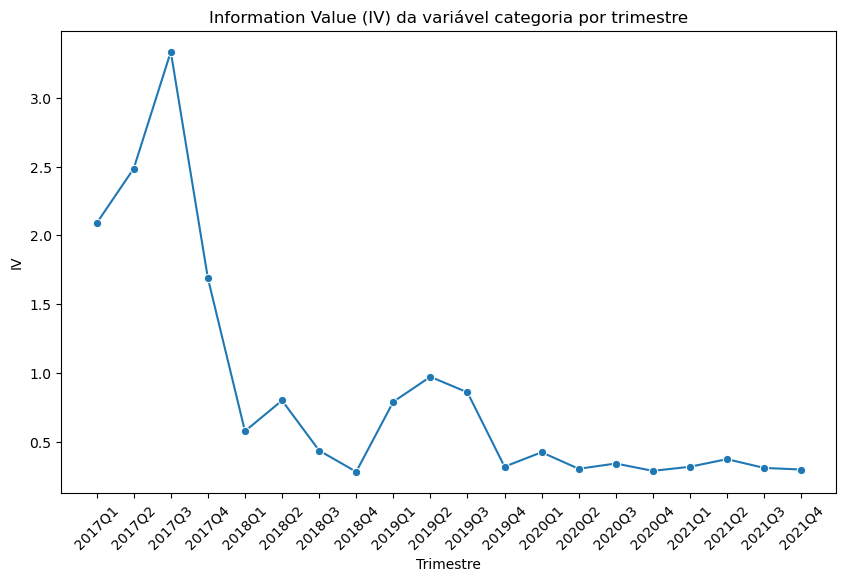

In [72]:
iv_trimestre_df['trimestre_str'] = iv_trimestre_df['trimestre'].astype(str)

plt.figure(figsize=(10,6))
sns.lineplot(data=iv_trimestre_df, x='trimestre_str', y='IV', marker='o')
plt.title('Information Value (IV) da variável categoria por trimestre')
plt.xlabel('Trimestre')
plt.xticks(rotation=45)
plt.show()


## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<span style="color:red">
O Information Value (IV) varia bastante no decorrer ao longo do tempo no decorrer dos trimestres.

A variável categoria é representativa no trimestre "2017Q3" e depois despenca no trimestre "2018Q1".

Tantas variações carecem de uma perspectiva de investigar o por que deste comportamento dos dados. (a) Pode dar causa a esse comportamento alguma mudança no próprio modelo de negócio no que tange às doações da Nota Fiscal Paulista. (b) Também podemos pensar em algum fator de desaceleração econômica, no caso de 2018 passávamos aqui no Brasil por uma crise política, econômica e social. (c) No gráfico a partir de 2020 as doações atingiram seu pior patamar com a Pandemia de Covid 19. Somado isso a economia parada e políticas públicas que atrasaram a vinda a vacina e consequente elevado número de óbitos.

De 2020 até 2022 as doações ficaram em um mesmo patamar. Isso nos diz indiretamente que a economia ainda não se recuperou. Só se faz doações se de alguma maneira se tem dinheiro sobrando. Se pensarmos que muitas empresas quebraram na economia e o índice de desemprego aumentou podemos entender que o dinheiro parou de circular.

</span> 

</span>
